<a href="https://colab.research.google.com/github/cocoflsl/joljak/blob/main/cyclegan_%EC%B5%9C%EC%A2%85%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## import

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ex7lfyea
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-ex7lfyea
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=33eba79378bcc90892a23a8e4ce6a6972f063c3f0f1dbf77656da28c1a72d439
  Stored in directory: /tmp/pip-ephem-wheel-cache-y5jcdxd0/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [3]:
import tensorflow as tf

In [50]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import numpy as np
import glob
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [5]:
source_dir = '/content/drive/MyDrive/졸업프로젝트/color clustering result/'
target_dir = '/content/drive/MyDrive/졸업프로젝트/outfit_items_dataset/upperwear/tshirt/'

## 입력 파이프라인

- 데이터 로딩 및 전처리


In [6]:
import random

def load_and_preprocess_image(image_path):
    # 이미지 파일을 읽어서 디코딩
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # PNG 이미지를 디코딩

    return image

# 이미지 파일들의 경로를 리스트로 가져오기
source_paths = glob.glob(source_dir + '/*.png')
target_paths = glob.glob(target_dir + '/*.png')

random.shuffle(source_paths)
random.shuffle(target_paths)

split_stand = int(len(source_paths) * 0.8)

train_src_paths = source_paths[:split_stand]
test_src_paths = source_paths[split_stand:]
train_tgt_paths = source_paths[:split_stand]
test_tgt_paths = source_paths[split_stand:]


# 데이터셋으로 변환
train_src_dataset = tf.data.Dataset.from_tensor_slices(train_src_paths)
train_src_dataset = train_src_dataset.map(load_and_preprocess_image)

test_src_dataset = tf.data.Dataset.from_tensor_slices(test_src_paths)
test_src_dataset = test_src_dataset.map(load_and_preprocess_image)

train_tgt_dataset = tf.data.Dataset.from_tensor_slices(train_tgt_paths)
train_tgt_dataset = train_tgt_dataset.map(load_and_preprocess_image)

test_tgt_dataset = tf.data.Dataset.from_tensor_slices(test_tgt_paths)
test_tgt_dataset = test_tgt_dataset.map(load_and_preprocess_image)

In [7]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [8]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [9]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [10]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [11]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [12]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

In [13]:
train_src = train_src_dataset.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_tgt = train_tgt_dataset.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_src = test_src_dataset.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_tgt = test_tgt_dataset.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
sample_src = next(iter(train_src))
sample_tgt = next(iter(train_tgt))

## Pix2Pix 모델 재사용

생성기 & 판별자 = pix2pix

- 인스턴스 정규화 사용
- resnet 대신 unet 사용 (단순화)
<br>
<br>

생성기 및 판별자 학습
- 생성기 `G`는 이미지 `X`를 이미지 `Y`로 변환하는 방법을 학습
- 생성기 `F`는 이미지 `Y`를 이미지 `X`로 변환하는 방법을 학습
- 판별자 `D_X`는 이미지 `X`와 생성된 이미지 `X`( `F(Y)` )를 구별하는 방법을 학습
- 판별자 `D_Y`는 이미지 `Y`와 생성된 이미지 `Y`(`G(X)`)를 구별하는 방법을 학습


In [15]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

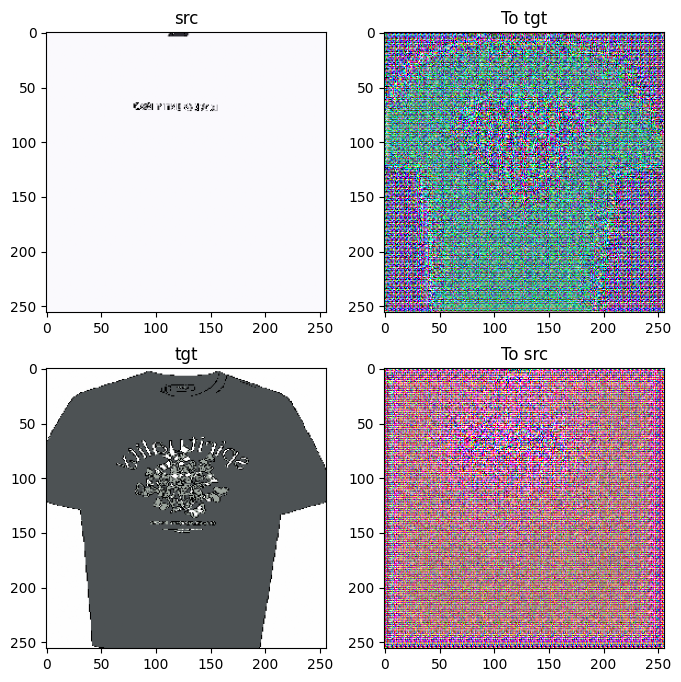

In [16]:
to_src = generator_g(sample_src)
to_tgt = generator_f(sample_tgt)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_src, to_tgt, sample_tgt, to_src]
title = ['src', 'To tgt', 'tgt', 'To src']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

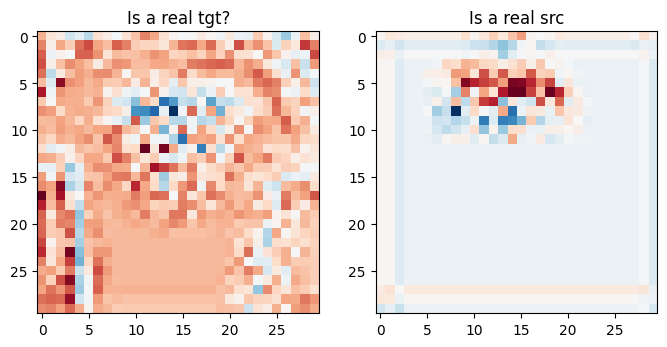

In [17]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real tgt?')
plt.imshow(discriminator_y(sample_tgt)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real src')
plt.imshow(discriminator_x(sample_src)[0, ..., -1], cmap='RdBu_r')

plt.show()

## 손실 함수

CycleGAN에는 훈련할 쌍으로 연결된 데이터가 없으므로 훈련 중에 입력 `x`와 대상 `y`의 쌍이 의미가 있다는 보장이 없기 때문에 네트워크가 올바른 매핑을 학습하도록 강제하기 위해 주기 일관성 손실이 제안됨

판별자 손실 및 생성기 손실 = pix2pix

In [18]:
LAMBDA = 10

In [19]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [21]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [22]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [23]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

모든 생성기 및 판별자의 옵티마이저를 초기화

In [24]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## 체크포인트

In [25]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## 훈련

In [26]:
EPOCHS = 10

In [27]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

- 예측
- 손실 계산
- 역전파를 사용하여 그래디언트를 계산
- 그래디언트를 옵티마이저에 적용

In [28]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

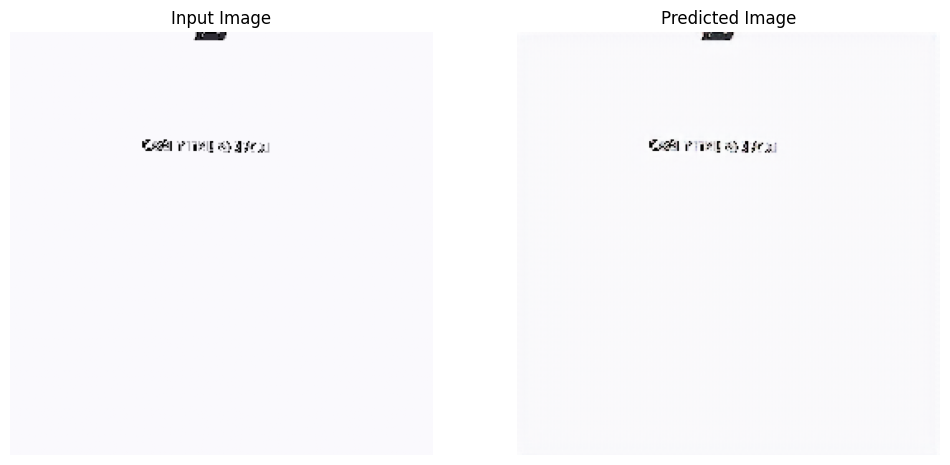

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Time taken for epoch 10 is 188.07212042808533 sec



In [29]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_src, train_tgt)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_src)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

## 테스트
: 에포크 추가 ...

In [ ]:
test = tf.io.read_file('/content/drive/MyDrive/test.png')
test = tf.image.decode_png(test, channels=3)
test = preprocess_image_train(test)
test = np.expand_dims(test, axis = 0)

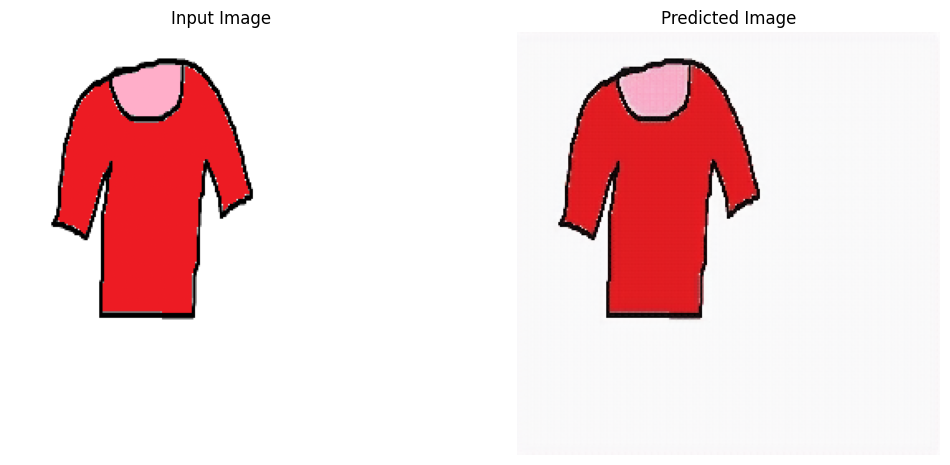

In [54]:
generate_images(generator_g, test)